# Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [2]:
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np

from src.Simulation import GIFnet_Simulation
from src.Tools import PSTH

# Load data

In [3]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network')
simfiles = {}
for cond in ['subsample_base', 'subsample_noIA']:
    for fname in os.listdir(os.path.join(DATA_PATH, cond)):
        if fname[-4:].lower() == 'hdf5' and 'test' not in fname:
            try:
                simfiles[cond + '_' + fname[:-5]] = GIFnet_Simulation(os.path.join(DATA_PATH, cond, fname), mode = 'r')
            except IOError:
                warnings.warn('Problem with file {}. Continuing.'.format(fname), RuntimeWarning)
        else:
            continue

/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Problem with file m_g_9.hdf5. Continuing.
  if __name__ == '__main__':
/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Problem with file m_g_5.hdf5. Continuing.
  if __name__ == '__main__':
/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Problem with file m_g_7.hdf5. Continuing.
  if __name__ == '__main__':
/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Problem with file m_g_14.hdf5. Continuing.
  if __name__ == '__main__':
/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Problem with file l_ng_6.hdf5. Continuing.
  if __name__ == '__main__':
/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/ipykernel_launcher.py:9:

In [4]:
simfiles.keys()

['subsample_noIA_l_ng_1',
 'subsample_noIA_l_ng_2',
 'subsample_noIA_l_ng_4',
 'subsample_noIA_l_ng_6',
 'subsample_noIA_l_ng_9',
 'subsample_noIA_m_g_8',
 'subsample_noIA_m_g_7',
 'subsample_noIA_m_g_4',
 'subsample_noIA_m_g_3',
 'subsample_noIA_m_g_2',
 'subsample_noIA_m_g_1',
 'subsample_base_l_ng_3',
 'subsample_base_l_ng_2',
 'subsample_base_l_ng_5',
 'subsample_base_l_ng_4',
 'subsample_base_l_ng_7',
 'subsample_base_l_ng_9',
 'subsample_base_l_ng_8',
 'subsample_base_m_g_11',
 'subsample_base_m_g_10',
 'subsample_base_m_g_15',
 'subsample_base_m_g_13',
 'subsample_base_m_g_12',
 'subsample_base_m_ng_15',
 'subsample_base_m_ng_10',
 'subsample_noIA_l_g_8',
 'subsample_base_m_g_8',
 'subsample_noIA_l_g_6',
 'subsample_noIA_l_g_7',
 'subsample_noIA_l_g_4',
 'subsample_base_m_g_4',
 'subsample_base_m_g_3',
 'subsample_base_m_g_2',
 'subsample_base_m_g_1',
 'subsample_noIA_l_g_1',
 'subsample_noIA_l_g_14',
 'subsample_noIA_l_g_15',
 'subsample_noIA_l_g_10',
 'subsample_noIA_l_g_11',


# Analysis
## Extract PSTH

In [5]:
PSTH_width = 25.

ser_PSTHs = {}
gaba_PSTHs = {}
for cond in simfiles.keys():
    
    ser_PSTHs[cond] = np.empty((simfiles[cond].get_no_sweeps(), simfiles[cond].get_no_timesteps()))
    if cond[-4:-2].lower() == '_g':
        gaba_PSTHs[cond] = np.empty((simfiles[cond].get_no_sweeps(), simfiles[cond].get_no_timesteps()))
    
    for sweep_no in range(simfiles[cond].get_no_sweeps()):
        ser_PSTHs[cond][sweep_no, :] = PSTH(
            simfiles[cond].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            simfiles[cond].get_no_ser_neurons()
        )
        if cond[-4:-2].lower() == '_g':
            gaba_PSTHs[cond][sweep_no, :] = PSTH(
                simfiles[cond].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                simfiles[cond].get_no_gaba_neurons()
            )

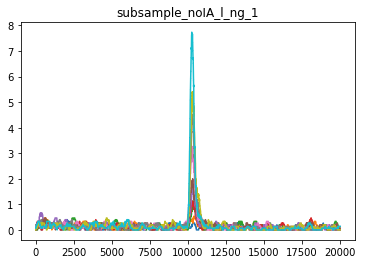

In [6]:
plt.subplot(111)
plt.title(ser_PSTHs.keys()[0])
plt.plot(ser_PSTHs[ser_PSTHs.keys()[0]].T)
plt.show()

## Plot I/O curves

In [7]:
def keyfilt_generator(dict_, prefix=None, model=None, baseline=None, gaba=None, rep=None):
    """Restrict _ delimited keys to specified values, or any for None."""
    for key in dict_:
        
        splitkey = key.split('_')
        assert len(splitkey) == 5, 'Expected {} to have 5 `_`-delimited entries, not {}'.format(key, len(splitkey))
        
        rejectkey = False
        for keyitem, filt in zip(splitkey, [prefix, model, baseline, gaba, rep]):
            if filt is None or keyitem in filt:
                continue
            else:
                rejectkey = True
                break
                
        if rejectkey:
            continue
        else:
            yield dict_[key]
        

In [8]:
def condname(prefix, model, baseline, gaba, rep):
    """Throwaway function to build keys in a consistent way.
    """
    return '_'.join([prefix, model, baseline, gaba, rep])

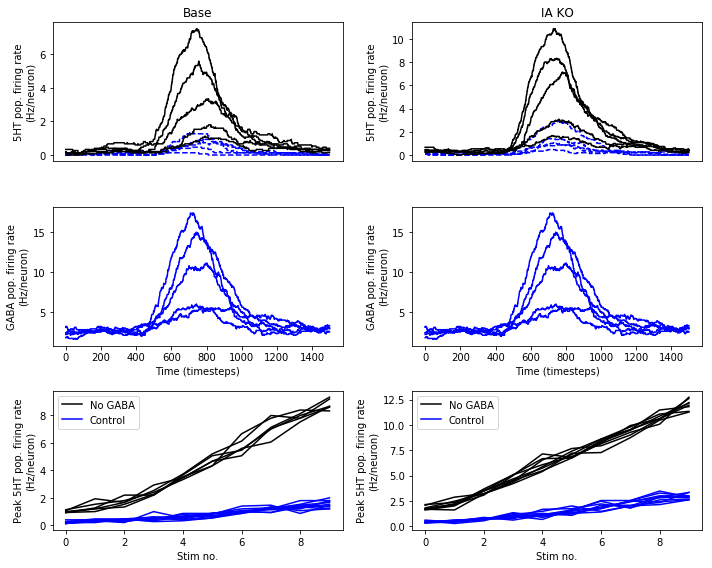

In [9]:
time_slice = slice(9500, 11000)

plt.figure(figsize = (10, 8))

axes = {}
spec_outer = gs.GridSpec(3, 2)

# Column 1: base model
axes['base_ser_psth'] = plt.subplot(spec_outer[0, 0])
axes['base_ser_psth'].set_title('Base')
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    axes['base_ser_psth'].plot(dat[::2, time_slice].T, 'b--')
    break  # Hacky way to plot only one example replicate.
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['ng'], None):
    axes['base_ser_psth'].plot(dat[::2, time_slice].T, 'k-')
    break
axes['base_ser_psth'].set_xticks([])
axes['base_ser_psth'].set_ylabel('5HT pop. firing rate\n(Hz/neuron)')

axes['base_gaba_psth'] = plt.subplot(spec_outer[1, 0])
for dat in keyfilt_generator(gaba_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    axes['base_gaba_psth'].plot(dat[::2, time_slice].T, 'b-')
    break
axes['base_gaba_psth'].set_ylabel('GABA pop. firing rate\n(Hz/neuron)')
axes['base_gaba_psth'].set_xlabel('Time (timesteps)')

axes['base_peak'] = plt.subplot(spec_outer[2, 0])
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['ng'], None):
    if ind == 0:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'k-', label='No GABA')
    else:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'k-')
    ind += 1
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['base'], ['m'], ['g'], None):
    if ind == 0:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'b-', label='Control')
    else:
        axes['base_peak'].plot(dat[:, time_slice].max(axis=1), 'b-')
    ind += 1
axes['base_peak'].set_ylabel('Peak 5HT pop. firing rate\n(Hz/neuron)')
axes['base_peak'].set_xlabel('Stim no.')
axes['base_peak'].legend()

# Column 2: Model with IA knocked out
axes['noIA_ser_psth'] = plt.subplot(spec_outer[0, 1])
axes['noIA_ser_psth'].set_title('IA KO')
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    axes['noIA_ser_psth'].plot(dat[::2, time_slice].T, 'b--')
    break  # Hacky way to plot only one example replicate.
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['ng'], None):
    axes['noIA_ser_psth'].plot(dat[::2, time_slice].T, 'k-')
    break
axes['noIA_ser_psth'].set_xticks([])
axes['noIA_ser_psth'].set_ylabel('5HT pop. firing rate\n(Hz/neuron)')

axes['noIA_gaba_psth'] = plt.subplot(spec_outer[1, 1])
for dat in keyfilt_generator(gaba_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    axes['noIA_gaba_psth'].plot(dat[::2, time_slice].T, 'b-')
    break
axes['noIA_gaba_psth'].set_ylabel('GABA pop. firing rate\n(Hz/neuron)')
axes['noIA_gaba_psth'].set_xlabel('Time (timesteps)')

axes['noIA_peak'] = plt.subplot(spec_outer[2, 1])
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['ng'], None):
    if ind == 0:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'k-', label='No GABA')
    else:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'k-')
    ind += 1
ind = 0
for dat in keyfilt_generator(ser_PSTHs, ['subsample'], ['noIA'], ['m'], ['g'], None):
    if ind == 0:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'b-', label='Control')
    else:
        axes['noIA_peak'].plot(dat[:, time_slice].max(axis=1), 'b-')
    ind += 1
axes['noIA_peak'].set_ylabel('Peak 5HT pop. firing rate\n(Hz/neuron)')
axes['noIA_peak'].set_xlabel('Stim no.')
axes['noIA_peak'].legend()

plt.tight_layout()
plt.show()

In [10]:
sweep_no = 8
spktimes = {'base': {'g': [], 'ng': []}, 'noIA': {'g': [], 'ng': []}}
for mod_type in spktimes:
    for gaba_cond in spktimes[mod_type]:
        i = 0
        for dat in keyfilt_generator(simfiles, ['subsample'], [mod_type], ['m'], [gaba_cond], None):
            print 'Getting spktimes {} {} {}'.format(mod_type, gaba_cond, i)
            spktimes_tmp = dat.get_ser_spktimes()
            spktimes_sw_tmp = np.concatenate(spktimes_tmp[sweep_no])
            spktimes_sw_tmp.sort()
            spktimes[mod_type][gaba_cond].append(spktimes_sw_tmp)
            i += 1

del mod_type, gaba_cond, dat, spktimes_tmp, spktimes_sw_tmp, i

Getting spktimes base g 0
Getting spktimes base g 1
Getting spktimes base g 2
Getting spktimes base g 3
Getting spktimes base g 4
Getting spktimes base g 5
Getting spktimes base g 6
Getting spktimes base g 7
Getting spktimes base g 8
Getting spktimes base g 9
Getting spktimes base g 10
Getting spktimes base ng 0
Getting spktimes base ng 1
Getting spktimes base ng 2
Getting spktimes base ng 3
Getting spktimes base ng 4
Getting spktimes base ng 5
Getting spktimes noIA g 0
Getting spktimes noIA g 1
Getting spktimes noIA g 2
Getting spktimes noIA g 3
Getting spktimes noIA g 4
Getting spktimes noIA g 5
Getting spktimes noIA g 6
Getting spktimes noIA g 7
Getting spktimes noIA g 8
Getting spktimes noIA g 9
Getting spktimes noIA ng 0
Getting spktimes noIA ng 1
Getting spktimes noIA ng 2
Getting spktimes noIA ng 3
Getting spktimes noIA ng 4
Getting spktimes noIA ng 5
Getting spktimes noIA ng 6
Getting spktimes noIA ng 7


/home/eharkin/miniconda3/envs/pseudopozz/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


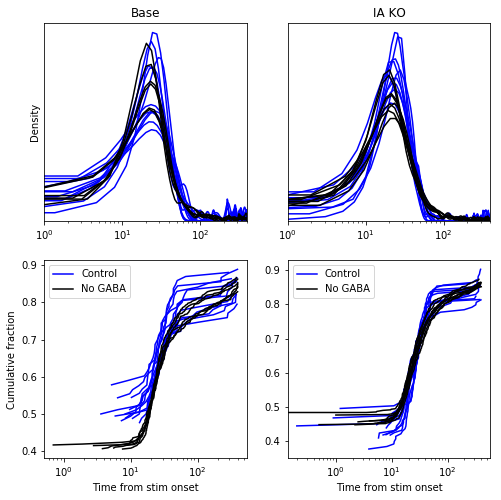

In [11]:
start_time = 1000
stop_time = 1400

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('Base')
for spktimes_tmp in spktimes['base']['g']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='b')
for spktimes_tmp in spktimes['base']['ng']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='k')
plt.yticks([])
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylabel('Density')

plt.subplot(223)
for i, spktimes_tmp in enumerate(spktimes['base']['g']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-', label='Control'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-'
        )
for i, spktimes_tmp in enumerate(spktimes['base']['ng']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-', label='No GABA'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-'
        )
plt.ylabel('Cumulative fraction')
plt.xlabel('Time from stim onset')
plt.legend()

plt.subplot(222)
plt.title('IA KO')
for spktimes_tmp in spktimes['noIA']['g']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='b')
for spktimes_tmp in spktimes['noIA']['ng']:
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, ax=plt.gca(), color='k')
plt.yticks([])
plt.xscale('log')
plt.xlim(1, stop_time - start_time)

plt.subplot(224)
for i, spktimes_tmp in enumerate(spktimes['noIA']['g']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-', label='Control'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'b-'
        )
for i, spktimes_tmp in enumerate(spktimes['noIA']['ng']):
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    if i == 0:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-', label='No GABA'
        )
    else:
        plt.semilogx(
            spktimes_tmp[mask] - start_time, 
            np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
            'k-'
        )
plt.xlabel('Time from stim onset')
plt.legend()

plt.show()

del spktimes_tmp, i

Top row: KDE plots of spike time PDF for each replicate. Bottom row: cumulative spike time distribution plots for each replicate.

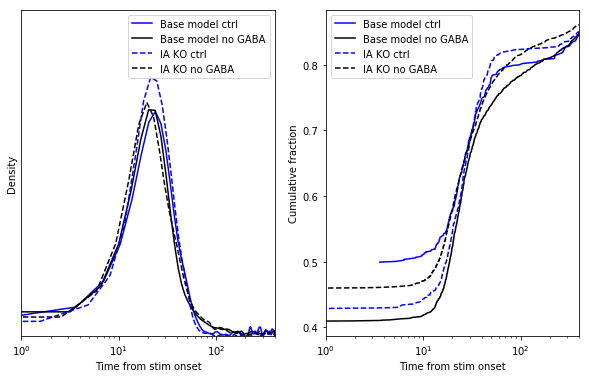

In [12]:
def masked_kde(spktimes, start_time, stop_time, **pltargs):
    spktimes_tmp = np.concatenate(spktimes)
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    sns.kdeplot(spktimes_tmp[mask] - start_time, **pltargs)


def masked_cumdist(spktimes, start_time, stop_time, **pltargs):
    spktimes_tmp = np.concatenate(spktimes).copy()
    spktimes_tmp.sort()
    mask = (spktimes_tmp >= start_time) & (spktimes_tmp < stop_time)
    plt.plot(
        spktimes_tmp[mask] - start_time, 
        np.linspace(1/len(spktimes_tmp), 1., len(spktimes_tmp))[mask], 
        **pltargs
    )


plt.figure(figsize=(10, 6))

plt.subplot(121)
masked_kde(spktimes['base']['g'], start_time, stop_time, color='b', label='Base model ctrl')
masked_kde(spktimes['base']['ng'], start_time, stop_time, color='k', label='Base model no GABA')
masked_kde(spktimes['noIA']['g'], start_time, stop_time, color='b', linestyle='--', label='IA KO ctrl')
masked_kde(spktimes['noIA']['ng'], start_time, stop_time, color='k', linestyle='--', label='IA KO no GABA')
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylim(0, plt.ylim()[1] * 1.2)
plt.yticks([])
plt.ylabel('Density')
plt.xlabel('Time from stim onset')
plt.legend()

plt.subplot(122)
masked_cumdist(spktimes['base']['g'], start_time, stop_time, color='b', label='Base model ctrl')
masked_cumdist(spktimes['base']['ng'], start_time, stop_time, color='k', label='Base model no GABA')
masked_cumdist(spktimes['noIA']['g'], start_time, stop_time, color='b', linestyle='--', label='IA KO ctrl')
masked_cumdist(spktimes['noIA']['ng'], start_time, stop_time, color='k', linestyle='--', label='IA KO no GABA')
plt.xscale('log')
plt.xlim(1, stop_time - start_time)
plt.ylabel('Cumulative fraction')
plt.xlabel('Time from stim onset')
plt.legend()

plt.show()

# Close all files

In [13]:
for fname in simfiles.keys():
    simfiles[fname].close()